In [1]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple
import time

@dataclass
class BlockHash:
    block_id: int
    original_hash: str
    quantized_hash: str
    timestamp: float = time.time()

@dataclass
class BlockResult:
    block_id: int
    quantized_data: np.ndarray
    original_data: np.ndarray
    hash_info: BlockHash
    processing_time_ms: float
    compression_ratio: float
    mean_squared_error: float

class HashVerifier:
    def __init__(self, verification_precision: int = 10):
        self.verification_precision = verification_precision
    
    def compute_block_hash(self, block_id: int, data: np.ndarray, is_original: bool = True, 
                        bit_precision: int = 4, method: str = "floating_point") -> str:
        """Compute deterministic hash based on quantization method"""
        if is_original:
            if method == "quantile":
                # Use quantile boundaries for quantile method
                sorted_data = np.sort(data)
                num_levels = 2 ** bit_precision
                boundaries = np.percentile(
                    sorted_data,
                    np.linspace(0, 100, num_levels + 1)[1:-1]
                )
                values = np.zeros(len(data), dtype=np.uint8)
                for i, value in enumerate(data):
                    values[i] = np.searchsorted(boundaries, value)
            else:  # floating_point
                # Use scaling for floating point method
                max_val = 2**bit_precision - 1
                abs_max = np.max(np.abs(data)) if len(data) > 0 else 1.0
                scale = abs_max / (max_val/2)
                scaled = np.clip(data / scale, -max_val/2, max_val/2)
                values = np.round(scaled + max_val/2)
        else:
            values = data
            
        # Convert to list of ints and create deterministic string representation
        value_list = [int(x) for x in values]
        data_str = f"block_{block_id}:" + ",".join(map(str, value_list))
        return self.sha256(data_str)
    
    def verify_block(self, block_id: int, original: np.ndarray, quantized: np.ndarray, 
                        bit_precision: int = 4, method: str = "floating_point") -> BlockHash:
            """Verify quantization result against original data"""
            original_hash = self.compute_block_hash(block_id, original, True, bit_precision, method)
            quantized_hash = self.compute_block_hash(block_id, quantized, False, bit_precision, method)
            
            return BlockHash(
                block_id=block_id,
                original_hash=original_hash,
                quantized_hash=quantized_hash
            )
    
    @staticmethod
    def sha256(input_str: str) -> str:
        """Compute SHA-256 hash and return first 8 characters"""
        import hashlib
        hash_obj = hashlib.sha256(input_str.encode())
        return hash_obj.hexdigest()[:8]

class VerifiedQuantizer:
    def __init__(self, block_size: int = 4096, verification_precision: int = 10, 
                 bit_precision: int = 4, method: str = "quantile"):
        self.block_size = block_size
        self.bit_precision = bit_precision
        self.method = method
        self.verifier = HashVerifier(verification_precision)
    
    def quantize_block(self, block_id: int, data: np.ndarray) -> BlockResult:
        """Quantize a block of data with verification"""
        start_time = time.time()
        
        data = np.asarray(data)
        
        if self.method == "quantile":
            quantized = self.quantize_quantile(data)
        else:  # floating_point
            quantized = self.quantize_floating_point(data)
        
        # Pass method to verifier
        hash_info = self.verifier.verify_block(
            block_id, data, quantized, 
            self.bit_precision, self.method
        )
        compression_ratio, mse = self.compute_metrics(data, quantized)
        
        return BlockResult(
            block_id=block_id,
            quantized_data=quantized,
            original_data=data,
            hash_info=hash_info,
            processing_time_ms=(time.time() - start_time) * 1000,
            compression_ratio=compression_ratio,
            mean_squared_error=mse
        )
    def quantize_quantile(self, data: np.ndarray) -> np.ndarray:
        """Quantize using quantile-based approach"""
        num_levels = 2 ** self.bit_precision
        sorted_data = np.sort(data)
        
        # Generate boundary points
        boundaries = np.percentile(
            sorted_data,
            np.linspace(0, 100, num_levels + 1)[1:-1]
        )
        
        # Initialize output array
        indices = np.zeros(len(data), dtype=np.uint8)
        
        # Assign values to levels
        for i, value in enumerate(data):
            # Find the appropriate bin
            level = np.searchsorted(boundaries, value)
            indices[i] = level
            
        return indices

    def quantize_floating_point(self, data: np.ndarray) -> np.ndarray:
        """Quantize using floating point scaling"""
        max_val = 2**self.bit_precision - 1
        abs_max = np.max(np.abs(data)) if len(data) > 0 else 1.0
        scale = abs_max / (max_val/2)
        
        scaled = np.clip(data / scale, -max_val/2, max_val/2)
        return np.round(scaled + max_val/2).astype(np.uint8)
    
    def compute_metrics(self, original: np.ndarray, quantized: np.ndarray) -> Tuple[float, float]:
        """Calculate metrics for quantization results"""
        # Compression ratio (32-bit float to n-bit int)
        compression_ratio = 32.0 / self.bit_precision
        
        # Mean squared error using proper dequantization
        if self.method == "quantile":
            # For quantile method, map back through quantile values
            sorted_orig = np.sort(original)
            quantiles = np.array_split(sorted_orig, 2**self.bit_precision)
            quantile_values = [np.mean(q) for q in quantiles]
            dequantized = np.array([quantile_values[i] for i in quantized])
        else:
            # For floating point method, reverse the scaling
            max_val = 2**self.bit_precision - 1
            abs_max = np.max(np.abs(original)) if len(original) > 0 else 1.0
            scale = abs_max / (max_val/2)
            dequantized = (quantized - max_val/2) * scale
        
        mse = np.mean((original - dequantized) ** 2)
        return compression_ratio, float(mse)

    def quantize_all_blocks(self, data: np.ndarray) -> List[BlockResult]:
        """Quantize all data in blocks"""
        data = np.asarray(data)
        blocks = np.array_split(data, np.ceil(len(data) / self.block_size))
        return [self.quantize_block(i, block) for i, block in enumerate(blocks)]

def test_quantization():
    # Generate test data
    np.random.seed(42)
    data = np.random.normal(0, 1, 1000)
    
    # Test both quantization methods
    methods = ["quantile", "floating_point"]
    for method in methods:
        print(f"\nTesting {method} quantization:")
        quantizer = VerifiedQuantizer(
            block_size=128,
            bit_precision=4,
            method=method
        )
        
        results = quantizer.quantize_all_blocks(data)
        
        # Show results for first block
        block = results[0]
        print(f"Processing Time: {block.processing_time_ms:.2f}ms")
        print(f"Compression Ratio: {block.compression_ratio:.2f}x")
        print(f"Mean Squared Error: {block.mean_squared_error:.6f}")
        print(f"Original Hash: {block.hash_info.original_hash}")
        print(f"Quantized Hash: {block.hash_info.quantized_hash}")
        print(f"First 5 quantized values: {block.quantized_data[:5]}")
        print(f"Hashes match: {block.hash_info.original_hash == block.hash_info.quantized_hash}")

if __name__ == "__main__":
    test_quantization()


Testing quantile quantization:
Processing Time: 6.83ms
Compression Ratio: 8.00x
Mean Squared Error: 0.019533
Original Hash: 8bada202
Quantized Hash: 8bada202
First 5 quantized values: [11  7 12 15  6]
Hashes match: True

Testing floating_point quantization:
Processing Time: 0.29ms
Compression Ratio: 8.00x
Mean Squared Error: 0.010670
Original Hash: c7a7857a
Quantized Hash: c7a7857a
First 5 quantized values: [ 9  7  9 12  7]
Hashes match: True


Using device: cpu

Benchmarking with data size: 1000

Benchmarking with data size: 10000

Benchmarking with data size: 100000

Benchmarking with data size: 1000000


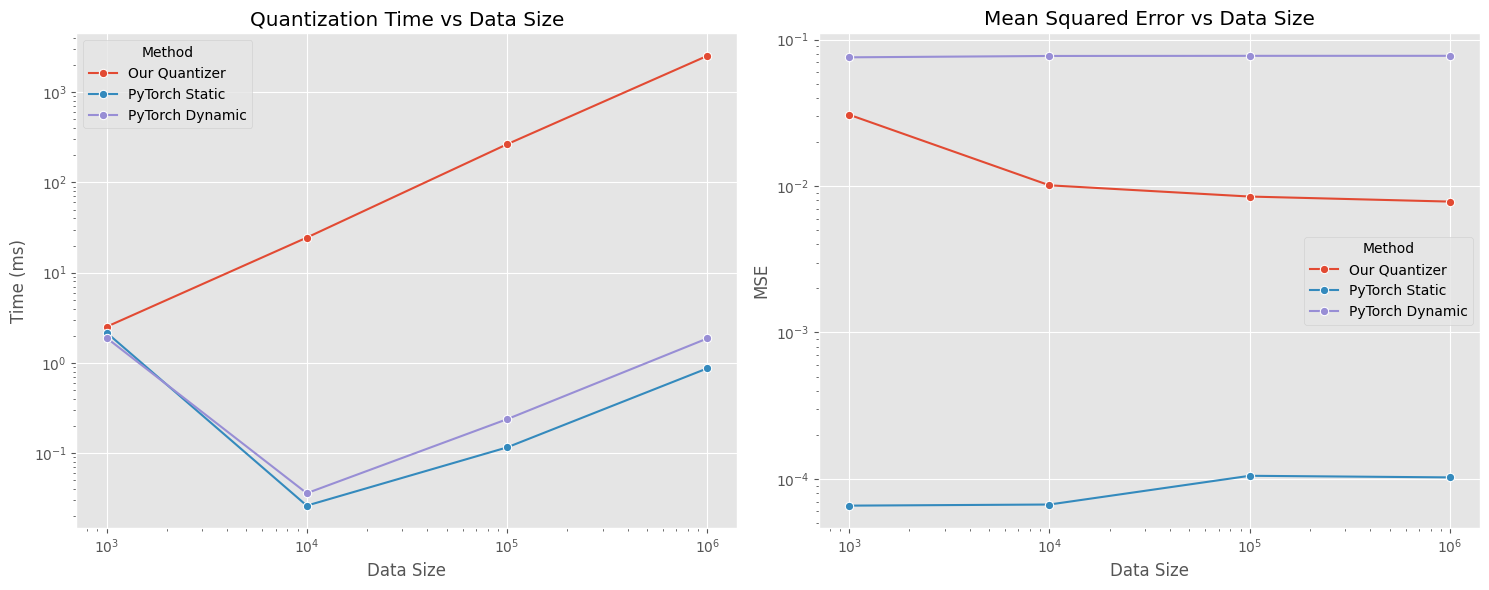


Summary Statistics:

Our Quantizer:
Average Time: 705.47 ms
Average MSE: 0.014291

PyTorch Static:
Average Time: 0.80 ms
Average MSE: 0.000085

PyTorch Dynamic:
Average Time: 1.01 ms
Average MSE: 0.077084


In [2]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import seaborn as sns
from dataclasses import dataclass
import pandas as pd

@dataclass
class BenchmarkResult:
    method: str
    data_size: int
    time_ms: float
    mse: float
    compression_ratio: float

class QuantizationBenchmark:
    def __init__(self, sizes: List[int] = None):
        if sizes is None:
            self.sizes = [1000, 10000, 100000, 1000000]
        else:
            self.sizes = sizes
        
        # Initialize PyTorch device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

    def generate_test_data(self, size: int) -> np.ndarray:
        """Generate test data with mixed distributions"""
        np.random.seed(42)  # For reproducibility
        data = np.concatenate([
            np.sin(np.linspace(0, 10, size // 3)),
            np.random.normal(0, 1, size // 3),
            np.random.uniform(-1, 1, size - 2 * (size // 3))
        ])
        return data

    def benchmark_our_quantizer(self, data: np.ndarray) -> Tuple[float, float]:
        """Benchmark our custom quantizer"""
        quantizer = VerifiedQuantizer(block_size=1024)
        
        start_time = time.time()
        results = quantizer.quantize_all_blocks(data)
        elapsed_ms = (time.time() - start_time) * 1000
        
        # Calculate average MSE across all blocks
        mse = np.mean([r.mean_squared_error for r in results])
        
        return elapsed_ms, mse

    def benchmark_pytorch_static(self, data: np.ndarray) -> Tuple[float, float]:
        """Benchmark PyTorch static quantization"""
        tensor = torch.from_numpy(data).float().to(self.device)
        
        start_time = time.time()
        # Quantize to int8
        qmin, qmax = 0, 255
        scale = (data.max() - data.min()) / (qmax - qmin)
        zero_point = qmin - data.min() / scale
        
        q_tensor = torch.quantize_per_tensor(tensor, scale, int(zero_point), torch.quint8)
        dq_tensor = q_tensor.dequantize()
        
        elapsed_ms = (time.time() - start_time) * 1000
        
        # Calculate MSE
        mse = torch.mean((tensor - dq_tensor) ** 2).item()
        
        return elapsed_ms, mse

    def benchmark_pytorch_dynamic(self, data: np.ndarray) -> Tuple[float, float]:
        """Benchmark PyTorch dynamic quantization"""
        tensor = torch.from_numpy(data).float().to(self.device)
        
        start_time = time.time()
        # Dynamic quantization (per channel)
        q_tensor = torch.quantize_per_channel(
            tensor.unsqueeze(0).unsqueeze(0),  # Add batch and channel dims
            torch.tensor([1.0]).to(self.device),  # scales
            torch.tensor([0]).to(self.device),   # zero_points
            0,  # axis
            torch.qint8
        )
        dq_tensor = q_tensor.dequantize().squeeze()
        
        elapsed_ms = (time.time() - start_time) * 1000
        
        # Calculate MSE
        mse = torch.mean((tensor - dq_tensor) ** 2).item()
        
        return elapsed_ms, mse

    def run_benchmarks(self) -> List[BenchmarkResult]:
        results = []
        
        for size in self.sizes:
            print(f"\nBenchmarking with data size: {size}")
            data = self.generate_test_data(size)
            
            # Our quantizer
            time_ms, mse = self.benchmark_our_quantizer(data)
            results.append(BenchmarkResult("Our Quantizer", size, time_ms, mse, 4.0))
            
            # PyTorch static
            time_ms, mse = self.benchmark_pytorch_static(data)
            results.append(BenchmarkResult("PyTorch Static", size, time_ms, mse, 4.0))
            
            # PyTorch dynamic
            time_ms, mse = self.benchmark_pytorch_dynamic(data)
            results.append(BenchmarkResult("PyTorch Dynamic", size, time_ms, mse, 4.0))
        
        return results

    def plot_results(self, results: List[BenchmarkResult]):
        """Create visualizations of benchmark results"""
        df = pd.DataFrame([(r.method, r.data_size, r.time_ms, r.mse) 
                          for r in results],
                         columns=['Method', 'Data Size', 'Time (ms)', 'MSE'])
        
        # Set style
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Time vs Data Size
        sns.lineplot(data=df, x='Data Size', y='Time (ms)', 
                    hue='Method', marker='o', ax=ax1)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_title('Quantization Time vs Data Size')
        ax1.grid(True)
        
        # Plot 2: MSE vs Data Size
        sns.lineplot(data=df, x='Data Size', y='MSE', 
                    hue='Method', marker='o', ax=ax2)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_title('Mean Squared Error vs Data Size')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        for method in df['Method'].unique():
            method_df = df[df['Method'] == method]
            print(f"\n{method}:")
            print(f"Average Time: {method_df['Time (ms)'].mean():.2f} ms")
            print(f"Average MSE: {method_df['MSE'].mean():.6f}")

def run_comparison():
    # Run benchmarks with various data sizes
    benchmark = QuantizationBenchmark()
    results = benchmark.run_benchmarks()
    
    # Plot results
    benchmark.plot_results(results)

if __name__ == "__main__":
    run_comparison()

In [10]:
import multiprocessing as mp
import uuid
import time
import gmpy2
import numpy as np
from hashlib import sha256
from typing import Dict, List, Tuple
from dataclasses import dataclass

@dataclass
class ProfilingResult:
    method: str
    data_size: int
    total_time: float
    breakdown: Dict[str, float]

# Worker function must be at module level for pickling
def worker_process(queue_in: mp.Queue, queue_out: mp.Queue):
    """Worker process for multiprocessing approach"""
    while True:
        msg = queue_in.get()
        if msg == "STOP":
            break
            
        block_id, data = msg
        start = time.perf_counter_ns()
        
        # Convert to gmpy2 numbers
        t0 = time.perf_counter_ns()
        data_mp = [gmpy2.mpfr(str(x)) for x in data]
        t1 = time.perf_counter_ns()
        
        # Calculate scale
        abs_max = max(abs(x) for x in data_mp)
        scale = abs_max / 127
        t2 = time.perf_counter_ns()
        
        # Quantize
        quantized = [int(gmpy2.round(x / scale)) for x in data_mp]
        t3 = time.perf_counter_ns()
        
        # Hash
        hash_str = sha256(str(quantized).encode()).hexdigest()[:8]
        t4 = time.perf_counter_ns()
        
        timings = {
            'gmpy2_conversion': (t1 - t0) / 1e6,
            'scale_calc': (t2 - t1) / 1e6,
            'quantization': (t3 - t2) / 1e6,
            'hashing': (t4 - t3) / 1e6,
        }
        
        queue_out.put((block_id, quantized, hash_str, timings))

class QuantizationProfiler:
    def __init__(self, num_workers: int = None):
        self.num_workers = num_workers or mp.cpu_count()
        
    def profile_numpy_approach(self, data_size: int = 10000) -> ProfilingResult:
        """Profile the numpy-based approach"""
        data = np.random.randn(data_size)
        timings = {}
        
        start = time.perf_counter_ns()
        
        # Scale calculation
        t0 = time.perf_counter_ns()
        abs_max = np.max(np.abs(data))
        scale = abs_max / 127.0
        t1 = time.perf_counter_ns()
        timings['scale_calc'] = (t1 - t0) / 1e6
        
        # Data scaling
        t0 = time.perf_counter_ns()
        scaled = np.clip(data / scale, -127, 127)
        t1 = time.perf_counter_ns()
        timings['data_scaling'] = (t1 - t0) / 1e6
        
        # Quantization
        t0 = time.perf_counter_ns()
        quantized = np.round(scaled).astype(np.int8)
        t1 = time.perf_counter_ns()
        timings['quantization'] = (t1 - t0) / 1e6
        
        # Hashing
        t0 = time.perf_counter_ns()
        hash_str = sha256(quantized.tobytes()).hexdigest()[:8]
        t1 = time.perf_counter_ns()
        timings['hashing'] = (t1 - t0) / 1e6
        
        total_time = (time.perf_counter_ns() - start) / 1e6
        timings['overhead'] = total_time - sum(timings.values())
        
        return ProfilingResult(
            method='numpy',
            data_size=data_size,
            total_time=total_time,
            breakdown=timings
        )
    
    def profile_mp_approach(self, data_size: int = 10000, block_size: int = 128) -> ProfilingResult:
        """Profile the multiprocessing + gmpy2 approach"""
        data = np.random.randn(data_size)
        start = time.perf_counter_ns()
        
        # Setup multiprocessing
        t0 = time.perf_counter_ns()
        queue_in = mp.Queue()
        queue_out = mp.Queue()
        workers = []
        
        for _ in range(self.num_workers):
            worker = mp.Process(
                target=worker_process,  # Note: using top-level function
                args=(queue_in, queue_out)
            )
            worker.start()
            workers.append(worker)
        t1 = time.perf_counter_ns()
        
        # Split data into blocks and distribute
        t2 = time.perf_counter_ns()
        blocks = [
            data[i:i + block_size].tolist()  # Convert to list for pickling
            for i in range(0, len(data), block_size)
        ]
        
        for i, block in enumerate(blocks):
            queue_in.put((i, block))
            
        # Collect results
        results = []
        timings_list = []
        for _ in range(len(blocks)):
            block_id, quantized, hash_str, timings = queue_out.get()
            results.append((block_id, quantized, hash_str))
            timings_list.append(timings)
        t3 = time.perf_counter_ns()
        
        # Cleanup
        for _ in workers:
            queue_in.put("STOP")
        for worker in workers:
            worker.join()
        t4 = time.perf_counter_ns()
        
        # Aggregate timings
        total_time = (time.perf_counter_ns() - start) / 1e6
        avg_timings = {
            key: sum(t[key] for t in timings_list) / len(timings_list)
            for key in timings_list[0].keys()
        }
        avg_timings['mp_setup'] = (t1 - t0) / 1e6
        avg_timings['data_distribution'] = (t2 - t1) / 1e6
        avg_timings['result_collection'] = (t3 - t2) / 1e6
        avg_timings['cleanup'] = (t4 - t3) / 1e6
        
        return ProfilingResult(
            method='multiprocessing+gmpy2',
            data_size=data_size,
            total_time=total_time,
            breakdown=avg_timings
        )

def run_profile_comparison(data_sizes=[1000, 10000, 100000]):
    """Run benchmark comparison"""
    profiler = QuantizationProfiler()
    results = []
    
    for size in data_sizes:
        print(f"\nProfiling with data size: {size}")
        
        # Profile numpy approach
        numpy_result = profiler.profile_numpy_approach(size)
        results.append(numpy_result)
        print(f"\nNumpy approach breakdown (total: {numpy_result.total_time:.2f}ms):")
        for op, time in numpy_result.breakdown.items():
            print(f"  {op}: {time:.2f}ms ({100*time/numpy_result.total_time:.1f}%)")
        
        # Profile multiprocessing approach
        mp_result = profiler.profile_mp_approach(size)
        results.append(mp_result)
        print(f"\nMP+gmpy2 approach breakdown (total: {mp_result.total_time:.2f}ms):")
        for op, time in mp_result.breakdown.items():
            print(f"  {op}: {time:.2f}ms ({100*time/mp_result.total_time:.1f}%)")
    
    return results

if __name__ == "__main__":

    results = run_profile_comparison([1000, 10000])

    # Or create a profiler instance and run specific tests
    profiler = QuantizationProfiler()
    numpy_result = profiler.profile_numpy_approach(1000)



Profiling with data size: 1000

Numpy approach breakdown (total: 0.30ms):
  scale_calc: 0.17ms (56.9%)
  data_scaling: 0.08ms (27.2%)
  quantization: 0.02ms (8.0%)
  hashing: 0.02ms (6.0%)
  overhead: 0.01ms (1.9%)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/envs/a0/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/a0/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/envs/a0/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'worker_process' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/a0/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
Traceback (most recent call last):
  File "<string>", li

KeyboardInterrupt: 